### Drug Classification Project with Transfer Learning(Transfer Learning ile İlaç Sınıflandırma)

#### 1. Business Problem:

- Bu projede VGG16 modelini kullanıyor olacağız.

### 2. Data Understanding:

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from keras_preprocessing.image import ImageDataGenerator # data augmentation
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
#from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

from pathlib import Path
import os.path

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings("ignore")

In [3]:
# load data

dataset = ("C:\\Users\\Monster\\Desktop\\dataaa\\Drug Vision\\Data Combined")
image_dir = Path(dataset)

filepaths = list(image_dir.glob(r"**/*.jpg")) + list(image_dir.glob(r"**/*.png")) 
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

In [5]:
filepaths = pd.Series(filepaths, name = "filepath").astype("str")
labels = pd.Series(labels, name = "labels")

In [8]:
filepaths.head(10)

0    C:\Users\Monster\Desktop\dataaa\Drug Vision\Da...
1    C:\Users\Monster\Desktop\dataaa\Drug Vision\Da...
2    C:\Users\Monster\Desktop\dataaa\Drug Vision\Da...
3    C:\Users\Monster\Desktop\dataaa\Drug Vision\Da...
4    C:\Users\Monster\Desktop\dataaa\Drug Vision\Da...
5    C:\Users\Monster\Desktop\dataaa\Drug Vision\Da...
6    C:\Users\Monster\Desktop\dataaa\Drug Vision\Da...
7    C:\Users\Monster\Desktop\dataaa\Drug Vision\Da...
8    C:\Users\Monster\Desktop\dataaa\Drug Vision\Da...
9    C:\Users\Monster\Desktop\dataaa\Drug Vision\Da...
Name: filepath, dtype: object

In [9]:
labels.head(10)

0    Alaxan
1    Alaxan
2    Alaxan
3    Alaxan
4    Alaxan
5    Alaxan
6    Alaxan
7    Alaxan
8    Alaxan
9    Alaxan
Name: labels, dtype: object

In [10]:
image_df = pd.concat([filepaths, labels], axis = 1)

image_df

,filepath,labels
0,C:\Users\Monster\Desktop\dataaa\Drug Vision\Da...,Alaxan
1,C:\Users\Monster\Desktop\dataaa\Drug Vision\Da...,Alaxan
2,C:\Users\Monster\Desktop\dataaa\Drug Vision\Da...,Alaxan
3,C:\Users\Monster\Desktop\dataaa\Drug Vision\Da...,Alaxan
4,C:\Users\Monster\Desktop\dataaa\Drug Vision\Da...,Alaxan
...,...,...
9995,C:\Users\Monster\Desktop\dataaa\Drug Vision\Da...,Neozep
9996,C:\Users\Monster\Desktop\dataaa\Drug Vision\Da...,Neozep
9997,C:\Users\Monster\Desktop\dataaa\Drug Vision\Da...,Neozep
9998,C:\Users\Monster\Desktop\dataaa\Drug Vision\Da...,Neozep


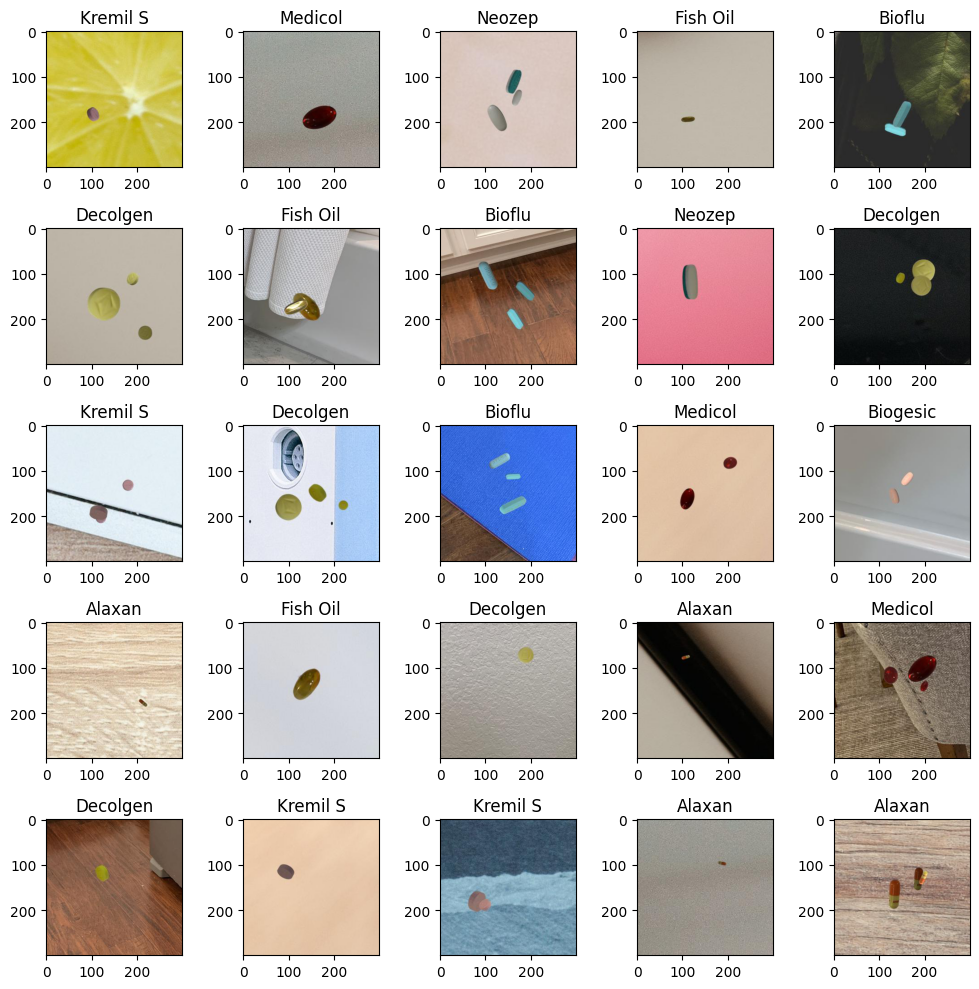

In [12]:
# veri görselleştirme

random_index = np.random.randint(0, len(image_df), 25)
fig, axes = plt.subplots(nrows = 5, ncols = 5, figsize = (10,10))
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.filepath[random_index[i]]))
    ax.set_title(image_df.labels[random_index[i]])

plt.tight_layout()

#### 3. Data Preparation:

In [13]:
# train-test split

train_df, test_df = train_test_split(image_df, test_size = 0.2, random_state=42, shuffle=True)

In [14]:
print(f"Eğitim veri seti boyutu: {train_df.shape}")
print(f"Test veri seti boyutu: {test_df.shape}")

Eğitim veri seti boyutu: (8000, 2)
Test veri seti boyutu: (2000, 2)


In [15]:
# data augmentation

train_generator = ImageDataGenerator(
                         preprocessing_function=preprocess_input,
                         validation_split = 0.2)

test_generator = ImageDataGenerator(
                         preprocessing_function=preprocess_input)                        

In [19]:
# eğitim, test ve val verilerini akışa alalım

train_images = train_generator.flow_from_dataframe(
                dataframe = image_df,
                x_col = "filepath", # görüntü path'i
                y_col = "labels",
                target_size = (224,224), # vgg 224 boyutunda kullanır verileri
                color_mode = "rgb",
                class_mode = "categorical",
                batch_size = 64,
                shuffle = True,
                seed = 42,
                subset = "training"
)

val_images = train_generator.flow_from_dataframe(
                dataframe = train_df,
                x_col = "filepath", # görüntü path'i
                y_col = "labels",
                target_size = (224,224), # vgg 224 boyutunda kullanır verileri
                color_mode = "rgb",
                class_mode = "categorical",
                batch_size = 64,
                shuffle = True,
                seed = 42,
                subset = "validation"
)

test_images = train_generator.flow_from_dataframe(
                dataframe = test_df,
                x_col = "filepath", # görüntü path'i
                y_col = "labels",
                target_size = (224,224), # vgg 224 boyutunda kullanır verileri
                color_mode = "rgb",
                class_mode = "categorical",
                batch_size = 64
)

Found 8000 validated image filenames belonging to 10 classes.
Found 1600 validated image filenames belonging to 10 classes.
Found 2000 validated image filenames belonging to 10 classes.


In [22]:
# Veri işleme pipeline (VGG16 için uygun hale getiriliyor)
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(224,224),          # 224x224'e yeniden boyutlandır
    tf.keras.layers.Lambda(preprocess_input)     # VGG16 için uygun normalize et
])

#### 4. Modelling - Training:

In [23]:
# VGG16: önceden eğitilmiş model(pretrained model)

pretrained_model = VGG16(input_shape = (224, 224, 3), # görüntünün boyutu
                         include_top = False, # sınıflandırma katmanını dahil etme
                         weights = "imagenet", # hangi veri seti ile eğitildiğini belirtir
                         pooling = "avg")

pretrained_model.trainable = False

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 23s 0us/step


In [28]:
# callback

checkpoint_path = "C://Deep Learning_Turkcell//pharmaceutical_drugs_and_vitamins_classification_model_checkpoint.weights.h5"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only = True,
                                      monitor = "val_accuracy",
                                      save_best_only = True)

In [30]:
# Earlystopping : 3 epoch kadar val_accuracy değerinde bir iyileşme olmazsa eğitimi durdur

early_stopping = EarlyStopping(monitor = 'val_accuracy', 
                               patience = 3,
                               restore_best_weights = True,
                               verbose = 1)

In [31]:
# build model using vgg16
# vgg16'ya kendi katmanlarımızı ekledik

inputs = pretrained_model.input
x = resize_and_rescale(inputs)
x = Dense(256, activation = "relu")(pretrained_model.output)
x = Dropout(0.2)(x)
x = Dense(256, activation = "relu")(x)
x = Dropout(0.2)(x)
outputs = Dense(10, activation = "softmax")(x)

model = Model(inputs = inputs, outputs = outputs)

In [32]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         131,3

 Total params: 14,914,378 (56.89 MB)

 Trainable params: 199,690 (780.04 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

- VGG16'nın trainable özelliğini kapattık bu nedenle yalnızca bizim vgg'nin sonuna eklediğimiz model(katmanlar) eğitilecek.

In [33]:
# compile

model.compile(optimizer = Adam(1e-4), loss = "categorical_crossentropy", metrics = ["accuracy"])

In [34]:
history = model.fit(train_images,
                    steps_per_epoch = len(train_images),
                    epochs = 50,
                    validation_data = val_images,
                    validation_steps = len(val_images),
                    callbacks = [early_stopping, checkpoint_callback])

Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 954s 8s/step - accuracy: 0.2151 - loss: 2.9536 - val_accuracy: 0.5000 - val_loss: 2.1045
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 943s 8s/step - accuracy: 0.5264 - loss: 1.4281 - val_accuracy: 0.6094 - val_loss: 1.9473
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 943s 8s/step - accuracy: 0.6548 - loss: 1.0378 - val_accuracy: 0.6538 - val_loss: 1.9135
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 950s 8s/step - accuracy: 0.7210 - loss: 0.8207 - val_accuracy: 0.6806 - val_loss: 1.9297
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 943s 8s/step - accuracy: 0.7684 - loss: 0.6971 - val_accuracy: 0.7075 - val_loss: 1.9322
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 945s 8s/step - accuracy: 0.8017 - loss: 0.5874 - val_accuracy: 0.7231 - val_loss: 2.0094
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 944s 8s/step - accuracy: 0.8178 - loss: 0.5343 - val_accuracy: 0.7281 - val_loss: 2.0118
Epoch 8/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 945s 8s/step - accuracy: 0.8361 - loss: 0.4759 - val_accu

#### 5. Evaluation:

In [35]:
# test 
loss, accuracy = model.evaluate(test_images, verbose = 1)

32/32 ━━━━━━━━━━━━━━━━━━━━ 202s 6s/step - accuracy: 0.7898 - loss: 3.0882
Loss: 3.0643982887268066, Accuracy: 0.7919999957084656


In [36]:
print(f"Loss: {loss:.3}, Accuracy: {accuracy:.3}")

Loss: 3.06, Accuracy: 0.792


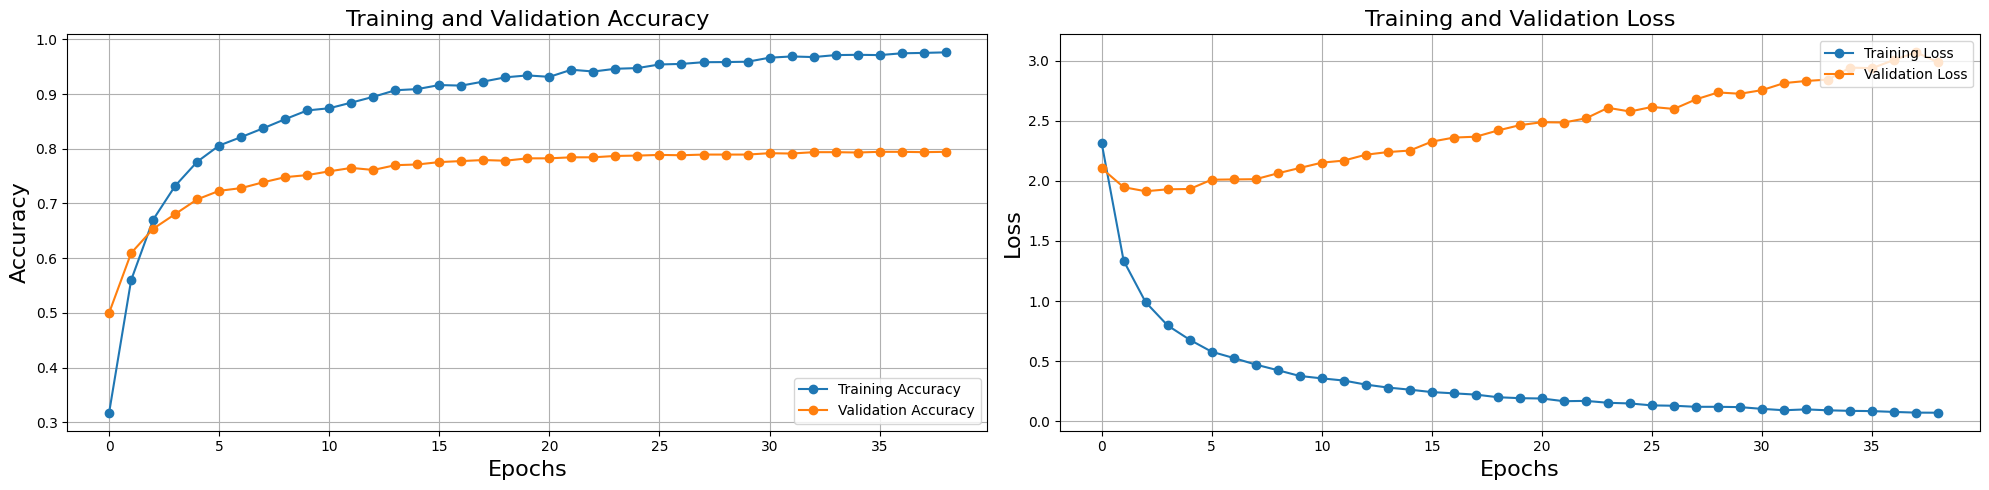

In [37]:
####################################################
# Accuracy Graph
####################################################

plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], marker = "o", label='Training Accuracy')
plt.plot(history.history['val_accuracy'], marker = "o", label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.grid(True)
plt.title('Training and Validation Accuracy', fontsize=16)


####################################################
# Loss Graph
####################################################

plt.subplot(1,2,2)
plt.plot(history.history['loss'], marker = "o", label='Training Loss')
plt.plot(history.history['val_loss'], marker = "o", label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.title('Training and Validation Loss', fontsize=16)
plt.grid(True)

plt.tight_layout()
plt.show()

In [38]:
pred = model.predict(test_images)
pred = np.argmax(pred, axis = 1)

32/32 ━━━━━━━━━━━━━━━━━━━━ 194s 6s/step


In [39]:
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())

In [40]:
pred = [labels[k] for k in pred]

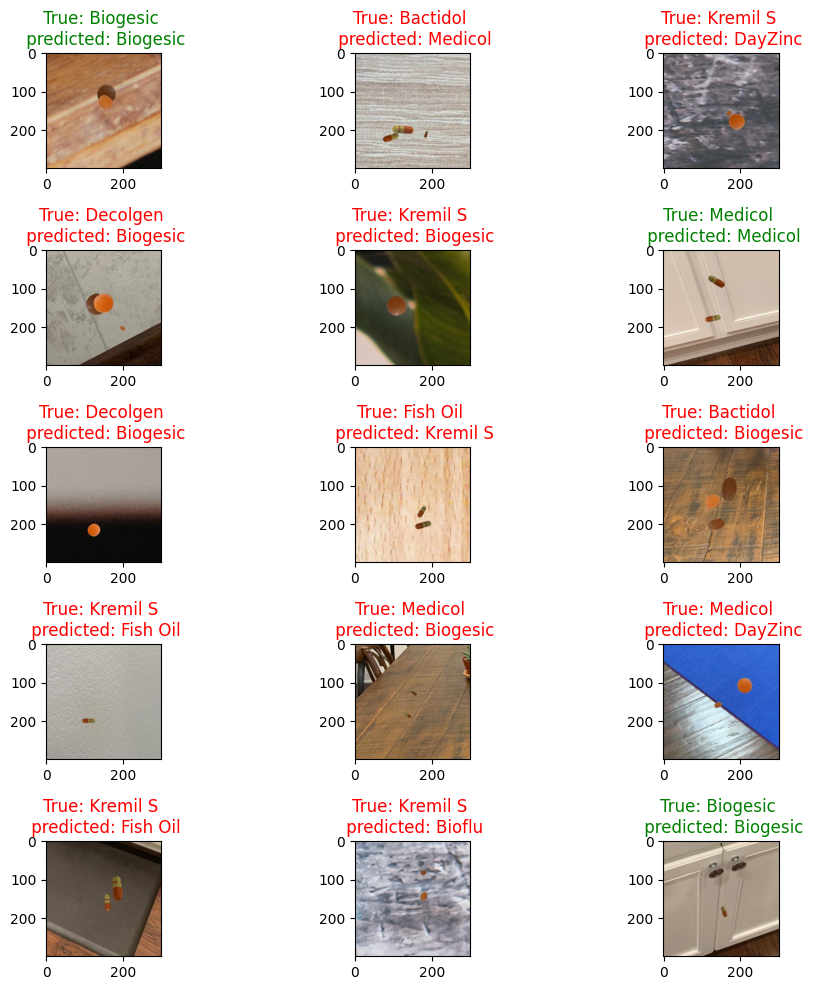

In [43]:
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows = 5, ncols = 3, figsize = (10,10))

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.filepath[random_index[i]]))
    if test_df.labels.iloc[random_index[i]] == pred[random_index[i]]: # doğru tahmin yaptıysak
        color = "green"
    else: color = "red"
        
    ax.set_title(f"True: {test_df.labels.iloc[random_index[i]]} \n predicted: {pred[random_index[i]]}", color=color)

plt.tight_layout()